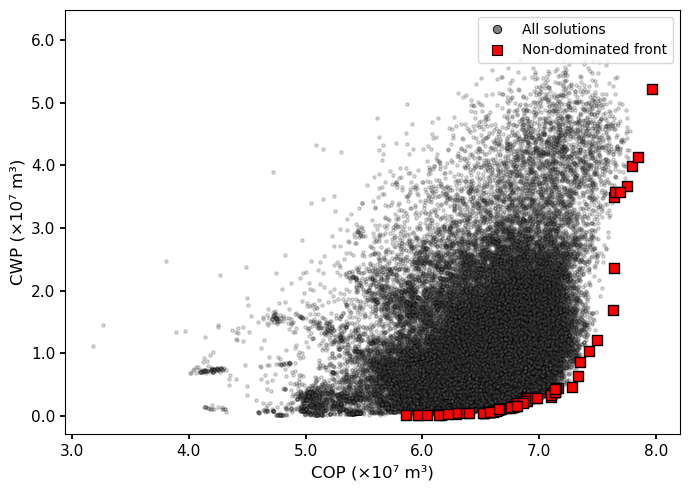

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter

formatter = FuncFormatter(lambda x, _: f"{x:,.0f}")
# ---------------------------------------------------
# Load dataset (robust separator handling)
# ---------------------------------------------------
df = pd.read_csv("datasets/MOU1D.csv", delimiter=";", engine="python")
objs = df.values[:, :2]   # use first two objectives only
# ---------------------------------------------------
# Objective directions
# True  -> minimize
# False -> maximize
# ---------------------------------------------------
minimize = np.array([False, True])

# ---------------------------------------------------
# Dominance check (mixed objectives)
# ---------------------------------------------------
def dominates(q, p, minimize):
    better_or_equal = True
    strictly_better = False

    for k in range(len(p)):
        if minimize[k]:
            if q[k] > p[k]:
                better_or_equal = False
                break
            if q[k] < p[k]:
                strictly_better = True
        else:
            if q[k] < p[k]:
                better_or_equal = False
                break
            if q[k] > p[k]:
                strictly_better = True

    return better_or_equal and strictly_better

# ---------------------------------------------------
# Update Pareto front with a batch
# ---------------------------------------------------
def update_pareto_front(current_pf, batch, minimize):
    new_pf = []

    for b in batch:
        dominated = False
        to_remove = []

        for i, p in enumerate(current_pf):
            if dominates(p, b, minimize):
                dominated = True
                break
            if dominates(b, p, minimize):
                to_remove.append(i)

        if not dominated:
            # remove dominated points from PF
            for idx in reversed(to_remove):
                current_pf.pop(idx)
            current_pf.append(b)

    return current_pf

# ---------------------------------------------------
# Batch-wise Pareto computation
# ---------------------------------------------------
batch_size = 2000
pareto_frontier = []

for start in range(0, len(objs), batch_size):
    batch = objs[start:start + batch_size]
    pareto_frontier = update_pareto_front(pareto_frontier, batch, minimize)

pf = np.array(pareto_frontier)

# ---------------------------------------------------
# Plot
# ---------------------------------------------------
plt.figure(figsize=(7, 5))
plt.style.use("default")
plt.scatter(
    objs[:, 0], objs[:, 1],
    color="grey", alpha=0.2, s=5,
    rasterized=True,
    label="All solutions",
    edgecolors='black'
)
plt.scatter(pf[:, 0], pf[:, 1], color="red", s=50, marker='s', edgecolors='black', label="Non-dominated front")
plt.xlabel("COP (×10⁷ m³)")
plt.ylabel("CWP (×10⁷ m³)")
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y/1e7:.1f}"))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y/1e7:.1f}"))

ax.tick_params(colors="black", labelsize=11, width=1.3)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markerfacecolor='grey',
        markeredgecolor='black',
        markeredgewidth=0.6,
        markersize=6,
        label='All solutions'
    ),
    Line2D(
        [0], [0],
        marker='s',
        linestyle='',
        markerfacecolor='red',
        markeredgecolor='black',
        markeredgewidth=0.8,
        markersize=7,
        label='Non-dominated front'
    )
]

ax.legend(
    handles=legend_elements,
    loc='upper right',
    frameon=True
)

for axis in [ax.xaxis, ax.yaxis]:
    axis.label.set_color("black")
    axis.label.set_size(12)
#plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
#plt.show()
plt.savefig("figures/MOU1D.pdf")

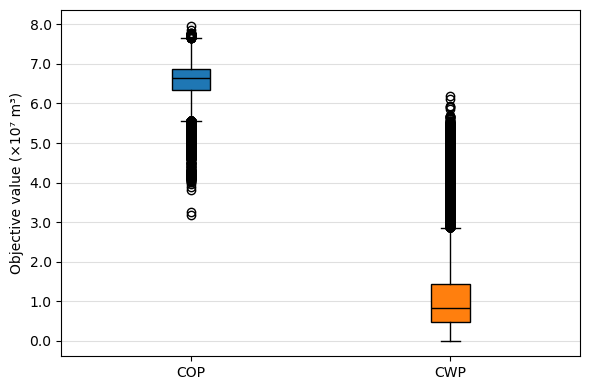

In [8]:
import matplotlib.pyplot as plt

obj_cols = ["COP", "CWP"]

plt.figure(figsize=(6, 4))
box = plt.boxplot(
    objs,
    tick_labels=obj_cols,
    showfliers=True,
    patch_artist=True
)

colors = ["tab:blue", "tab:orange"]

for element in ["boxes", "whiskers", "caps", "medians"]:
    plt.setp(box[element], color="black")

for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

plt.ylabel("Objective value (×10⁷ m³)")
plt.grid(True, axis="y", alpha=0.4)
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y/1e7:.1f}"))
plt.tight_layout()
plt.savefig("figures/boxplot_MOU1D.pdf")
plt.show()
